In [ ]:
use_colab=True
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT_DATA = '/content/drive/MyDrive/RAKUTEN/data/'
    !pip install timm
    !pip install transformers
    !wget --load-cookies '/content/drive/MyDrive/RAKUTEN/ens.fr_cookies.txt' 'https://challengedata.ens.fr/participants/challenges/59/download/supplementary-files'
    !tar -xvf 'supplementary-files'
    !cd '/content/drive/MyDrive/RAKUTEN/'
else:
    #!cd /Users/samperochon/MVA/Deep_Learning/Project/code/GazeCapture/pytorch
    ROOT_DATA = '/Users/samperochon/MVA/Sparse Representations/Kaggle/data'

In [29]:
cd '/content/drive/MyDrive/RAKUTEN/'

/content/drive/MyDrive/RAKUTEN


# Experiment 

In [61]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from PIL import Image

from glob import glob 
import json
import os
import shutil
import time


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import f1_score
from sklearn import svm

from transformers import BertTokenizer, BertModel

# For the ViT
import timm

# Local import
from tools import (ImgAugTransform, ImageDataset, ImageDatasetTEST, ImageTextDataset, TextDataset, Metric, generate_batch, generate_batch_Test)

class CustomBertModel(torch.nn.Module):

    def __init__(self, dropout):
        super(CustomBertModel, self).__init__()

        
        self.encoder   =  BertModel.from_pretrained('cl-tohoku/bert-base-japanese-v2')
        for param in self.encoder.parameters(): 
                param.requires_grad = False
        self.fc1 = torch.nn.Linear(768, 450)
        self.fc2 = torch.nn.Linear(450, 200)
        self.fc3 = torch.nn.Linear(200, 19)
        #self.batchNorm = nn.BatchNorm1d(num_features=450)
        self.dropout = nn.Dropout(dropout)


    def forward(self, tokens_tensor):
        text_features  = self.encoder.forward(input_ids=tokens_tensor,return_dict=True)
        text_features  = text_features['pooler_output'].squeeze(0)
        text_features = F.relu(self.dropout(self.fc1(text_features)))
        text_features = F.relu(self.dropout(self.fc2(text_features)))
        logits = self.fc3(text_features)

        return logits

    def relaxation(self,type_relax):
        if type_relax=="soft":
            for name,param in self.named_parameters():
                if name.startswith('encoder.encoder.layer.11') or name.startswith('encoder.pooler.dense'):
                    param.requires_grad = True
        elif type_relax=="hard":
            for param in self.encoder.parameters(): 
                param.requires_grad = True
    
    
    

class Experiment():
    def __init__(self, # General Properties
                         root_data, model_type = 'DenseNet', use_text = False,  epochs=30, start_epoch = 0, batch_size = 256, optimizer = 'AdamW', head_model = 'sequential',
                         lr=0.01, lr_decay_epoch = 10, momentum = 0.9, augment = True, weight_decay = 1e-2, dropout = 0.5, relaxation_type = None,
                         print_freq = 10, resume_path = '', pos_weight = False, item_caption = False, shuffle = True, troncature = 512, betas = (0.95, 0.9995),
                         split_train_val = 0.8, verbose=True, debug=False,
                         # Properties for DenseNet model
                         denseNet_attr = {}, 
                         # Properties for the ViT model
                         vit_attr = {}, inception_attr={}, resnet_attr={}):
        
        # General properties
        self.root_data = root_data
        self.dir_path = None
        self.json_path = None
        self.print_freq = print_freq
        self.resume_path = resume_path
        
        # Architectrure properties
        self.model_type = model_type if not use_text else 'Bert'
        self.use_text = use_text
        self.head_model = head_model
        self.relaxation_type = relaxation_type
        self.item_caption = item_caption
        self.troncature = troncature
    
        
        # Hyperparameters
        self.epochs = epochs
        self.start_epoch = start_epoch
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.lr = lr
        self.lr_decay_epoch = lr_decay_epoch # Decay LR by a factor 10 every lr_decay_epoch epoch
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.dropout = dropout
        self.pos_weight = pos_weight
        self.betas = betas
        
        
        # Data parameters
        self.augment = augment
        self.shuffle = shuffle
        self.split_train_val = split_train_val
        self.verbose = verbose
        self.debug = debug
        self.cuda = torch.cuda.is_available()
        
        # Models attributes
        self.denseNet_attr = {'layers' : 100, 'growth' : 12, 'droprate' : 0, 'augment' : True, 'reduce' : 0.5,
                               'bottleneck' : True, 'name' : 'DenseNet_BC_100_12'}
        self.vit_attr = vit_attr
        self.inception_attr = inception_attr
        self.resnet_attr = resnet_attr
        
        # Load the data, dataLoaders, etc...
        self.trainLoader, self.valLoader = self._retrieveData()
        
        # Initialize the model
        self.model = self._retrieveModel()

        # Create experiment folder
        self.initExperimentPath()
        
        # Criterion definition
        if self.pos_weight:
            nbr_labels_positive = torch.tensor([25673,71831,34014,33338,2383,8303,21697,28814,8353,12597,25017,10378,24582,10355,23583,12911,3325,51751,14534]) #number of labels
            nbr_labels_negative = nbr_labels_positive.sum()*torch.ones(19)-nbr_labels_positive
            coeffs = nbr_labels_negative/nbr_labels_positive    #coefficients for each label
            if self.cuda:
                coeffs = coeffs.cuda()
            self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=coeffs)
        else:
            self.criterion = torch.nn.BCEWithLogitsLoss()

        # Define Optimizer
        if self.optimizer =='SGD':
            self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr,
                                            momentum=self.momentum,
                                            nesterov=True,
                                            weight_decay=self.weight_decay)    
        elif self.optimizer =='AdamW':
            self.optimizer = torch.optim.AdamW(self.model.parameters(), betas = self.betas, lr = self.lr, weight_decay = self.weight_decay)

        # Save some metrics: _epoch_only is composed of the metric at the end of each epochs (ie has Number_of_epochs values), wereas _all is composed of Number_of_epochs*Number_of_batches values.
        self.losses_train_epoch = Metric()
        self.losses_train_batch = Metric()
        self.f1_train_epoch = Metric()
        self.f1_train_batch = Metric()
        
        self.losses_val_epoch = Metric()
        self.losses_val_batch = Metric()
        self.f1_val_epoch = Metric()
        self.f1_val_batch = Metric()
        self.best_f1 = 0     

    def _retrieveData(self):
        """
            Return the Train and Test data loader, based on the training data available.
        """
        print('Retrieving the data...')
        # Load the training X and Y data
        XTrain = pd.read_csv(os.path.join(self.root_data,'X_train_12tkObq.csv'), index_col=0)
        YTrain = pd.read_csv(os.path.join(self.root_data,'Y_train_num.csv'), index_col=0)
        # Parse the label string target "['Black','Orange']" -> ['Black', 'Orange']
        #YTrain['color_tags'] = YTrain['color_tags'].apply(lambda x: ast.literal_eval(x))
        # Parse the string information: '[1 0 0 0 0 1 0 0 0 0 ]' -> [1, 0, 0, 0, 0, 0, 1, 0, 0, 0 ,0] 
        YTrain['color_tags_num'] = YTrain['color_tags_num'].apply(lambda x: [float(i) for i in x.strip('[]').split(' ')])    
        
        

        if self.use_text:
            
            # Load text features 
            #Xtrain_item_name = torch.load(os.path.join(self.root_data,'data_rakuten/Xtrain_item_name.pt'))
            #Xtrain_item_caption = torch.load(os.path.join(self.root_data,'data_rakuten/Xtrain_item_caption.pt'))
            Ytrain_label = torch.load(os.path.join(self.root_data,'data_rakuten/Ytrain_label.pt'))
            Ytrain_label = Ytrain_label.transpose(1,0)
            
            train_df_X = XTrain.iloc[:int(Ytrain_label.shape[0]*self.split_train_val)]
            train_Y_label = Ytrain_label[:int(Ytrain_label.shape[0]*self.split_train_val)]
            
            
            val_df_X = XTrain.iloc[int(Ytrain_label.shape[0]*self.split_train_val):]
            val_Y_label = Ytrain_label[int(Ytrain_label.shape[0]*self.split_train_val):]
            
            #X_features=torch.cat((Xtrain_item_name,Xtrain_item_caption),0)
                                      
            #train_df_X = XTrain.iloc[:int(X_features.shape[1]*self.split_train_val)]
            #train_df_Y = YTrain.iloc[:int(X_features.shape[1]*self.split_train_val)]
                                      
            #val_df_X = XTrain.iloc[int(X_features.shape[1]*self.split_train_val):]
            #val_df_Y = YTrain.iloc[:int(X_features.shape[1]*self.split_train_val):]
                         
            # Create datasets
            if self.debug:
                
                trainTextDataset =  TextDataset(train_df_X.iloc[:100], train_Y_label[:100].transpose(1,0), self.item_caption, self.troncature)
                valTextDataset =  TextDataset(val_df_X.iloc[:100], val_Y_label[:100].transpose(1,0), self.item_caption, self.troncature)
                
                trainTextLoader = torch.utils.data.DataLoader(trainTextDataset, batch_size=self.batch_size,shuffle=self.shuffle, collate_fn=generate_batch)
                valTextLoader = torch.utils.data.DataLoader(valTextDataset, batch_size=self.batch_size,shuffle=False, collate_fn=generate_batch)

                #trainDataset = ImageTextDataset(train_df_X, train_df_Y, X_features,  self.root_data, dataset_type='training', augment=self.augment, model_type=self.model_type)
                #valDataset = ImageTextDataset(val_df_X, val_df_Y, X_features, self.root_data, dataset_type='validation', augment=self.augment, model_type=self.model_type)   
                return(trainTextLoader, valTextLoader)
            
                #trainDataset = ImageTextDataset(train_df_X.iloc[:100], train_df_Y.iloc[:100], X_features,  self.root_data, dataset_type='training', augment=self.augment, model_type=self.model_type)
                #valDataset = ImageTextDataset(val_df_X.iloc[:100], val_df_Y.iloc[:100], X_features,  self.root_data, dataset_type='validation', augment=self.augment, model_type=self.model_type)
            else:
                trainTextDataset =  TextDataset(train_df_X, train_Y_label.transpose(1,0), self.item_caption, self.troncature)
                valTextDataset =  TextDataset(val_df_X, val_Y_label.transpose(1,0), self.item_caption, self.troncature)
                
                trainTextLoader = torch.utils.data.DataLoader(trainTextDataset, batch_size=self.batch_size,shuffle=self.shuffle, collate_fn=generate_batch)
                valTextLoader = torch.utils.data.DataLoader(valTextDataset, batch_size=self.batch_size,shuffle=False, collate_fn=generate_batch)

                #trainDataset = ImageTextDataset(train_df_X, train_df_Y, X_features,  self.root_data, dataset_type='training', augment=self.augment, model_type=self.model_type)
                #valDataset = ImageTextDataset(val_df_X, val_df_Y, X_features, self.root_data, dataset_type='validation', augment=self.augment, model_type=self.model_type)   
                return(trainTextLoader, valTextLoader)
            
        else:
            
        
            # Split tre training data into train and validation sets
            #train_df_X, train_df_Y, val_df_X, val_df_Y = self._splitTrainVal(XTrain, YTrain, fraction=self.split_train_val)
            
            
            train_df_X = XTrain.iloc[:int(len(XTrain)*self.split_train_val)]
            train_df_Y = YTrain.iloc[:int(len(XTrain)*self.split_train_val)]

            
            val_df_X = XTrain.iloc[int(len(XTrain)*self.split_train_val):]
            val_df_Y = YTrain.iloc[:int(len(XTrain)*self.split_train_val)]


            # Create datasets
            if self.debug:
                trainImageDataset = ImageDataset(train_df_X.iloc[:100], train_df_Y.iloc[:100], self.root_data, dataset_type='training', augment=self.augment, model_type=self.model_type)
                valImageDataset = ImageDataset(val_df_X.iloc[:100], val_df_Y.iloc[:100], self.root_data, dataset_type='validation', augment=self.augment, model_type=self.model_type)
            else:
                trainImageDataset = ImageDataset(train_df_X, train_df_Y, self.root_data, dataset_type='training', augment=self.augment, model_type=self.model_type)
                valImageDataset = ImageDataset(val_df_X, val_df_Y, self.root_data, dataset_type='validation', augment=self.augment, model_type=self.model_type)

            # Create Datasets
            trainLoader = torch.utils.data.DataLoader(trainImageDataset,batch_size=self.batch_size, shuffle=self.shuffle, num_workers=2)
            valLoader = torch.utils.data.DataLoader(valImageDataset,batch_size=self.batch_size, shuffle=False, num_workers=2)
            
            return(trainLoader, valLoader)

    
    def _retrieveModel(self):
        print('Retrieving the model...')
        
        if self.model_type == 'DenseNet':
            # Model creation
            model = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
            for param in model.parameters():
                param.requires_grad = False
                # Replace the last fully-connected layer
                # Parameters of newly constructed modules have requires_grad=True by default
            model.classifier = nn.Linear(1024, 19) 
            print('DenseNet model loaded!!!\nNumber of model parameters to optimize: {}\n'.format(sum([p.data.nelement() for p in model.parameters() if p.requires_grad])))
            
        elif self.model_type == 'vit':
            model = timm.create_model('vit_large_patch16_224', pretrained=True)
            for param in model.parameters():
                param.requires_grad = False
                # Replace the last fully-connected layer
                # Parameters of newly constructed modules have requires_grad=True by default
            model  = self._relaxation(model, type_relax = self.relaxation_type)
            if self.head_model == 'sequential':
                model.head = nn.Sequential(nn.Linear(1024, 500),
                                          nn.BatchNorm1d(num_features=500),
                                          nn.ReLU(),
                                          nn.Dropout(self.dropout),
                                          nn.Linear(500, 19))
            if self.head_model == 'linear':        
                model.head = nn.Linear(1024, 19)
                                      
            print('ViT model loaded!!!\nNumber of model parameters to optimize: {}\n'.format(sum([p.data.nelement() for p in model.parameters() if p.requires_grad])))
        elif self.model_type == 'inception':
            model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
            for param in model.parameters():
                param.requires_grad = False
                # Replace the last fully-connected layer
                # Parameters of newly constructed modules have requires_grad=True by default
            if self.head_model == 'sequential':
                model.fc = nn.Sequential(nn.Linear(2048, 500),
                                          nn.BatchNorm1d(num_features=500),
                                          nn.ReLU(),
                                          nn.Dropout(self.dropout),
                                          nn.Linear(500, 19))
            if self.head_model == 'linear':        
                model.fc = nn.Linear(2048, 19)
            model = self._relaxation(model)
            print('Inception model loaded!!!\nNumber of model parameters to optimize: {}\n'.format(sum([p.data.nelement() for p in model.parameters() if p.requires_grad])))
        elif self.model_type=='resnet':

            model = torchvision.models.resnet152(pretrained=True)
            for param in model.parameters():
                param.requires_grad = False
                # Replace the last fully-connected layer
                # Parameters of newly constructed modules have requires_grad=True by default
            model.fc = torch.nn.Linear(model.fc.in_features, 19)
            print('DenseNet model loaded!!!\nNumber of model parameters to optimize: {}\n'.format(sum([p.data.nelement() for p in model.parameters() if p.requires_grad])))
            
        elif self.model_type =='Bert':
            model  = CustomBertModel(self.dropout)
            model.relaxation('soft')
            print('DenseBertNet model loaded!!!\nNumber of model parameters to optimize: {}\n'.format(sum([p.data.nelement() for p in model.parameters() if p.requires_grad])))
        
        # Send to cuda if available
        if torch.cuda.is_available():
            model.to('cuda')

        # optionally resume from a checkpoint
        if self.resume_path is not '':
            if os.path.isfile(self.resume_path):
                checkpoint = torch.load(self.resume_path, map_location=torch.device('cpu') if not torch.cuda.is_available() else None)
                self.start_epoch = checkpoint['epoch']
                self.best_f1 = checkpoint['best_f1']
                if self.model_type=='vit':
                    if self.relaxation_type in ['soft', 'hard']:
                      model.load_state_dict(checkpoint['state_dict'])
                    else:
                      model.head.load_state_dict(checkpoint['state_dict'])
                elif self.model_type=='DenseNet':
                    model.classifier.load_state_dict(checkpoint['state_dict'])
                elif self.model_type in ['inception', 'resnet']:
                    model.fc.load_state_dict(checkpoint['state_dict'])
                print("loaded checkpoint '{}' (epoch {}) - Best performance: {}".format(self.resume_path, checkpoint['epoch'], self.best_f1))
            else:
                print("/!\ No checkpoint found at '{}'".format(self.resume_path))
        return model
    
    def train(self):
        for epoch in range(self.epochs):
            # Divide the LR by a factor 10 every self.lr_decay_epoch epoch
            self._adjust_learning_rate(epoch)
            
            # Train for 1 epoch
            loss_final, f1_final = self.train_one_epoch(epoch)
            
            # Update metrics
            self.losses_train_epoch.update(loss_final)
            self.f1_train_epoch.update(f1_final)
            print('FINAL F1 score at the end of the training of epoch {}: {}'.format(epoch,f1_final))
            # Validate on the Validation set
            loss_final, f1_final = self.validate(epoch)
            
            # Update metrics
            self.losses_val_epoch.update(loss_final)
            self.f1_val_epoch.update(f1_final)
            print('FINAL F1 score at the end of the validation of epoch {}: {}'.format(epoch,f1_final))

            # Save metrics to the Json file
            self.save()
            
            # remember best f1 and save checkpoint
            if self.f1_val_epoch.val > self.best_f1:
                worthSaving = True
                print('Found better model')
            else:
                print("Didn't found better model")
                worthSaving = False
            self._save_checkpoint({'epoch': epoch + 1,
                                    'state_dict': self.model.head.state_dict() if ((self.model_type=='vit') and (self.relaxation_type  not in ['soft', 'hard'])) else
                                                   self.model.state_dict() if ((self.model_type=='vit') and (self.relaxation_type in ['soft', 'hard'])) else
                                                   self.model.classifier.state_dict() if self.model_type=='DenseNet' else
                                                   self.model.state_dict() if self.model_type=='Bert' else
                                                   self.model.fc.state_dict() if self.model_type in ['inception', 'resnet'] else
                                                   self.model.state_dict(),
                                    'best_f1': max(self.f1_val_epoch.val, self.best_f1)},
                                    is_best =worthSaving,
                                    filename = 'checkpoint_{}.pth.tar'.format(epoch))
            if self.f1_val_epoch.val > self.best_f1:
                self.best_f1 = self.f1_val_epoch.val
        return
            
    def train_one_epoch(self, epoch):
        """Train for one epoch on the training set"""
        
        batch_time = Metric()
        losses = Metric()
        f1 = Metric()

        # switch to train mode
        self.model.train()

        end = time.time()
        for i, (input, target) in enumerate(self.trainLoader):
            target = target.cuda()
            input = input.cuda()

            # compute output
            output = self.model(input)
            
            if self.model_type == 'inception':
                output = output.logits
            
            # Compute metrics and record
            loss = self.criterion(output, target)
            
            # Update metrics
            losses.update(loss.item(), input.size(0))
            f1.update(f1_score((torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int), target.cpu().detach().numpy(), average='weighted'), input.size(0))
            
            # Will help to compute the epoch-level F1-score
            if i==0:
                predictionMemory = (torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)
                targetMemory = target.cpu().detach().numpy()
            else:
                predictionMemory = np.concatenate((predictionMemory,(torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)), axis=0)
                targetMemory = np.concatenate((targetMemory,target.cpu().detach().numpy()), axis=0)


            # compute gradient and do SGD step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % self.print_freq == 0:
                print('Epoch: [{0}][{1}/{2}]\t''Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t''Loss {loss.val:.4f} ({loss.avg:.4f})\t''F1 {f1.val:.4f} ({f1.avg:.4f})\t'.format(epoch, i, len(self.trainLoader), batch_time=batch_time,loss=losses, f1=f1))
       
        self.losses_train_batch.merge(losses)
        self.f1_train_batch.merge(f1)

        return losses.avg, f1_score(predictionMemory, targetMemory, average='weighted')
    
    def validate(self, epoch):
        """Perform validation on the validation set"""
        batch_time = Metric()
        losses = Metric()
        f1 = Metric()
        
        # switch to evaluate mode
        self.model.eval()

        end = time.time()
        for i, (input, target) in enumerate(self.valLoader):
            target = target.cuda()
            input = input.cuda()

            # compute output
            output = self.model(input)
            
            # Compute metrics and record 
            loss = self.criterion(output, target)
            losses.update(loss.item(), input.size(0))
            f1.update(f1_score((torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int), target.cpu().detach().numpy(), average='weighted'), input.size(0))
            if i==0:
                predictionMemory = (torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)
                targetMemory = target.cpu().detach().numpy()
            else:
                predictionMemory = np.concatenate((predictionMemory,(torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)), axis=0)
                targetMemory = np.concatenate((targetMemory,target.cpu().detach().numpy()), axis=0)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            

            if i % self.print_freq == 0:
                print('Validation: [{0}/{1}]\t''Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t''Loss {loss.val:.4f} ({loss.avg:.4f})\t''F1 {f1.val:.4f} ({f1.avg:.4f})\t'.format(i, len(self.valLoader), batch_time=batch_time,loss=losses, f1=f1))
        

        self.f1_val_batch.merge(f1)
        self.losses_val_batch.merge(losses)        
        return losses.avg, f1_score(predictionMemory, targetMemory, average='weighted')
    
    
    def initExperimentPath(self):
        
        if not os.path.isdir(os.path.join(self.root_data, 'experiments')):
            os.mkdir(os.path.join(self.root_data, 'experiments'))
            
        if not os.path.isdir(os.path.join(self.root_data, 'experiments', self.model_type)):
            os.mkdir(os.path.join(self.root_data, 'experiments', self.model_type))
            os.mkdir(os.path.join(self.root_data, 'experiments', self.model_type,'0'))

        
        experimentNumber = np.max([int(os.path.basename(path)) for path in glob(os.path.join(self.root_data, 'experiments', self.model_type, '*'))])+1
        dir_path = os.path.join(self.root_data, 'experiments', self.model_type, str(experimentNumber))
        print('Doing experiment {}!'.format(experimentNumber))

        os.mkdir(dir_path)
        os.mkdir(os.path.join(dir_path, 'models'))
        os.mkdir(os.path.join(dir_path, 'figures'))
        
        json_path = os.path.join(dir_path, 'experiment_log.json')
        self.dir_path = dir_path
        self.json_path = json_path
        
        trainLoader = self.trainLoader
        valLoader = self.valLoader
        model = self.model
        
        del self.trainLoader, self.valLoader, self.model
        with open(json_path, 'w') as outfile:
            json.dump(self.__dict__, outfile)
            
        self.trainLoader, self.valLoader, self.model = trainLoader, valLoader, model
        return
    
    def retrieveExperiment(self, ExperimentNumber=None, path = None):
        """
            This functions aims at retrieving the best model from all the experiments. 
            You can either predefince the experiment number and the epoch, or look over all the losses of all experiments and pick the model having the best performances.
            
            /!\ Not implemented yet for the Rakuten challenge 
        """
        if path is None:
          path = os.path.join(self.root_data, 'experiments',self.model_type,str(ExperimentNumber), self.model_type+'_model_best.pth.tar')

        self.dir_path = os.path.join(self.root_data, 'experiments',self.model_type,str(ExperimentNumber))
        self.resume_path = os.path.join(self.root_data, 'experiments',self.model_type,str(ExperimentNumber), self.model_type+'_model_best.pth.tar')

        with open(os.path.join(self.root_data, 'experiments',self.model_type,str(ExperimentNumber),'experiment_log.json')) as jsonFile:
            data = json.load(jsonFile)
            
            # Load attributes
            #self._load_attributes(data)
            
            # Load model

            if os.path.isfile(path):
                checkpoint = torch.load(path, map_location=torch.device('cpu') if not torch.cuda.is_available() else None)
                self.start_epoch = checkpoint['epoch']
                self.best_f1 = checkpoint['best_f1']
                if self.model_type=='vit':
                    if self.relaxation_type in ['soft', 'hard']:
                      self.model.load_state_dict(checkpoint['state_dict'])
                    else:
                      self.model.head.load_state_dict(checkpoint['state_dict'])
                elif self.model_type=='DenseNet':
                    self.model.classifier.load_state_dict(checkpoint['state_dict'])
                elif self.model_type in ['inception', 'resnet']:
                    self.model.fc.load_state_dict(checkpoint['state_dict'])
                elif self.model_type=='Bert':
                    self.model.load_state_dict(checkpoint['state_dict'])
                else:
                    self.model.load_state_dict(checkpoint['state_dict'])
                print("loaded checkpoint '{}' (epoch {}) - Best performance: {}".format(path, checkpoint['epoch'], self.best_f1))
            else:
                print("/!\ No checkpoint found at '{}'".format(path))
                
        print('Experiment number {} led to best loss (BCE): {}'.format(ExperimentNumber, self.best_f1))
        self.f1_train_epoch.plot()
        self.f1_val_epoch.plot()
        return  
    
    def createSubmissionKaggle(self, path = None):
        if path is None:
            path = self.dir_path
            
        test_df_X = pd.read_csv(os.path.join(self.root_data,'X_test_gDTIJPh.csv'), index_col=0)
        
        # Create Datasets
        if self.use_text:
            testTextDataset = TextDataset(test_df_X, None, self.item_caption , self.troncature, test=True)
            testLoader = torch.utils.data.DataLoader(testTextDataset, batch_size=self.batch_size, shuffle=False, collate_fn =generate_batch_Test)

        else:
            testImageDataset = ImageDatasetTEST(test_df_X, self.root_data, model_type=self.model_type)
            testLoader = torch.utils.data.DataLoader(testImageDataset,batch_size=256, shuffle=False)

        # switch to evaluate mode
        self.model.cuda()
        self.model.eval()
        
        for i, (input) in enumerate(testLoader):
            input = input.cuda()

            # compute output
            output = self.model(input)
            if i==0:
                predictionMemory = (torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)
            else:
                predictionMemory = np.concatenate((predictionMemory,(torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)), axis=0)
        
        idx2color={ 0: "Beige",1:"Black",2:"Blue",3:"Brown",4:"Burgundy",5:"Gold",6:"Green",7:"Grey",
                    8:"Khaki",9:"Multiple Colors",10:"Navy",11:"Orange",12:"Pink",
                   13:"Purple",14:"Red",15:"Silver",16:"Transparent",17:"White",18:"Yellow"}
                 
        labels = [[idx2color[i]  for i in range(len(item)) if item[i]==1] for item in predictionMemory]
        submission_df = pd.DataFrame({'color_tags':labels})
        self.submissionKaggle = submission_df
        submission_df.to_csv(os.path.join(path,'submissionKaggle.csv'))
        return  
    
    def save(self):
        with open(self.json_path) as jsonFile:
            data = json.load(jsonFile)
            data['losses_train_epoch'] = self.losses_train_epoch.values
            data['losses_train_batch'] = self.losses_train_batch.values
            data['f1_train_epoch'] = self.f1_train_epoch.values
            data['f1_train_batch'] = self.f1_train_batch.values
            data['losses_val_epoch'] = self.losses_val_epoch.values
            data['losses_val_batch'] = self.losses_val_batch.values
            data['f1_val_epoch'] = self.f1_val_epoch.values
            data['f1_val_batch'] = self.f1_val_batch.values

        with open(self.json_path, 'w') as outfile:
            json.dump(data, outfile)
      
        return
    
    def _retrieveBestModel(self):
        raise NotImplemented

        min_loss = np.inf
        bestExperiment = None
        paths = glob(os.path.join(self.root_data, 'experiments', '*'))
        for path in paths:
             with open(os.path.join(path,'experiment_log.json')) as jsonFile:
                data = json.load(jsonFile)
                losses = data['losses']

                if len(losses)>0 and np.min(losses)<min_loss:
                    min_loss = np.min(losses)
                    bestExperiment = os.path.basename(path)
                    bestEpoch = np.argmin(losses)
        return bestExperiment, bestEpoch
    
    def _splitTrainVal(self, df_X, df_Y, fraction=0.8):
        # splitting dataframe in a particular size 
        train_df_X = df_X.sample(frac=fraction) 
        val_df_X = df_X.drop(train_df_X.index)

        train_df_Y = df_Y.iloc[train_df_X.index]
        val_df_Y = df_Y.drop(train_df_X.index)
        return train_df_X.reset_index(drop=True), train_df_Y.reset_index(drop=True), val_df_X.reset_index(drop=True), val_df_Y.reset_index(drop=True)
    
    def _adjust_learning_rate(self, epoch):
        """Sets the learning rate to the initial LR decayed by 10 after 150 and 225 epochs"""
        self.lr = self.lr * (0.5 ** (epoch // self.lr_decay_epoch))
        print('Learning rate at epoch {}: {}'.format(epoch, self.lr))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr
                                      
    def _relaxation(self, model ):

      if self.model_type == 'vit':

          if self.relaxation_type=="soft":
              for name,param in model.named_parameters():
                  if name.startswith('blocks.20') or name.startswith('blocks.21') or name.startswith('blocks.22') or name.startswith('blocks.23') :
                      param.requires_grad = True
          elif self.relaxation_type=="hard":
              for name,param in model.named_parameters():
                  param.requires_grad = True     
      elif self.model_type == 'inception':

          if self.relaxation_type=="soft":
              for name,param in model.named_parameters():
                  if name.startswith('Mixed_7c'):
                      param.requires_grad = True
          elif self.relaxation_type=="hard":
            print('No hard relaxatio  implemented for inception ')
            pass
              
      return model    
    
    def _save_checkpoint(self, state, is_best, filename='checkpoint.pth.tar'):
        """Saves checkpoint to disk"""
        filename = os.path.join(self.dir_path, 'models', filename)
                                             
        if self.model_type in ['vit', 'Bert'] and is_best:
            torch.save(state, os.path.join(self.dir_path,self.model_type+'_model_best.pth.tar'))                                 
        else:
            torch.save(state, filename)
            if is_best:
                shutil.copyfile(filename, os.path.join(self.dir_path,self.model_type+'_model_best.pth.tar'))
    
    def _load_attributes(self, data):
                
        # General properties
        #self.root_data = data['root_data']
        #self.experiment_path = data['experiment_path']
        #self.json_path = data['json_path']
        #self.model_type = data['model_type']
        #self.epochs = data['epochs']
        #self.start_epoch = data['start_epoch']
        #self.batch_size = data['batch_size']
        #self.lr = data['lr']
        #self.lr_decay_epoch = data['lr_decay_epoch'] # Decay LR by a factor 10 every lr_decay_epoch epoch
        #self.momentum = data['momentum']
        #self.augment = data['augment'] if 'augment' in data.keys() else False
        #self.weight_decay = data['weight_decay']
        #self.print_freq = data['print_freq']
        #self.resume_path = os.path.join(self.dir_path,self.model_type+'_model_best.pth.tar')
        #self.split_train_val = data['split_train_val']
        #self.debug = data['debug']
        #self.cuda = torch.cuda.is_available()
        #self.best_f1 = data['best_f1']
        #Metrics
        #self.losses_train_epoch.load(data["losses_train_epoch"])
        #self.losses_train_batch.load(data["losses_train_batch"])
        #self.f1_train_epoch.load(data["f1_train_epoch"])
        #self.f1_train_batch.load(data["f1_train_batch"])
        
        #self.losses_val_epoch.load(data["losses_val_epoch"])
        self.losses_val_batch.load(data["losses_val_batch"])
        self.f1_val_epoch.load(data["f1_val_epoch"])
        self.f1_val_batch.load(data["f1_val_batch"])
        
        # Models attributes
        #self.denseNet_attr = data['denseNet_attr']
        #self.vit_attr = data['vit_attr']
        #self.inception_attr = data['inception_attr']
        #self.resnet_attr = data['resnet_attr']
        return
    


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
InceptionExperiment = Experiment(ROOT_DATA, model_type = 'inception', epochs=50, batch_size = 64, relaxation_type = 'soft', head_model = 'sequential',
                         lr=0.0001, lr_decay_epoch = 10, momentum = 0.9, weight_decay = 1e-2, print_freq = 10, resume_path = '',
                         split_train_val = 0.8,  debug=False, betas = (0.95, 0.9995), augment = True,)

Retrieving the data...
Retrieving the model...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Inception model loaded!!!
Number of model parameters to optimize: 7111819

Doing experiment 27!


In [ ]:
InceptionExperiment.train()

Learning rate at epoch 0: 0.0001
Epoch: [0][0/2652]	Time 2.200 (2.200)	Loss 0.7186 (0.7186)	F1 0.1298 (0.1298)	
Epoch: [0][10/2652]	Time 1.695 (1.001)	Loss 0.6470 (0.6766)	F1 0.1448 (0.1591)	
Epoch: [0][20/2652]	Time 1.627 (0.941)	Loss 0.5699 (0.6441)	F1 0.2046 (0.1635)	
Epoch: [0][30/2652]	Time 1.574 (0.924)	Loss 0.5222 (0.6135)	F1 0.2086 (0.1669)	


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: [0][40/2652]	Time 1.663 (0.913)	Loss 0.5182 (0.5862)	F1 0.1755 (0.1676)	
Epoch: [0][50/2652]	Time 1.873 (0.916)	Loss 0.4547 (0.5612)	F1 0.1096 (0.1778)	
Epoch: [0][70/2652]	Time 1.647 (0.914)	Loss 0.3810 (0.5192)	F1 0.2353 (0.1932)	
Epoch: [0][80/2652]	Time 1.568 (0.911)	Loss 0.3727 (0.5004)	F1 0.2200 (0.2058)	
Epoch: [0][90/2652]	Time 1.682 (0.909)	Loss 0.3640 (0.4854)	F1 0.3198 (0.2175)	
Epoch: [0][100/2652]	Time 1.659 (0.908)	Loss 0.3439 (0.4715)	F1 0.3942 (0.2308)	
Epoch: [0][110/2652]	Time 1.599 (0.906)	Loss 0.3138 (0.4594)	F1 0.4704 (0.2471)	
Epoch: [0][120/2652]	Time 1.601 (0.906)	Loss 0.3575 (0.4485)	F1 0.5477 (0.2658)	
Epoch: [0][130/2652]	Time 1.679 (0.905)	Loss 0.3190 (0.4389)	F1 0.5517 (0.2803)	
Epoch: [0][140/2652]	Time 1.672 (0.907)	Loss 0.2886 (0.4291)	F1 0.5453 (0.2973)	
Epoch: [0][150/2652]	Time 1.707 (0.907)	Loss 0.3108 (0.4210)	F1 0.4426 (0.3087)	
Epoch: [0][160/2652]	Time 1.876 (0.911)	Loss 0.2592 (0.4146)	F1 0.5384 (0.3185)	
Epoch: [0][170/2652]	Time 1.811 (

In [4]:
# Model partiellement défreezer, 
vitExp = Experiment(ROOT_DATA, model_type = 'vit', epochs=30, start_epoch = 0, batch_size = 64, optimizer = 'AdamW',relaxation_type = 'soft',
                        lr=0.0001, lr_decay_epoch = 4, momentum = 0.9, weight_decay = 3e-2, print_freq = 100, resume_path = '',dropout = 0.6, 
                        split_train_val = 0.8, verbose = True, debug = False, augment = True, betas = (0.95, 0.9995),
                        # Properties for the ViT model
                        vit_attr = {})

Retrieving the data...
Retrieving the model...


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p16_224-4ee7a4dc.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_large_p16_224-4ee7a4dc.pth


ViT model loaded!!!
Number of model parameters to optimize: 50907915

Doing experiment 102!


In [ ]:
vitExp.train()

In [7]:
BertExperiment = Experiment(ROOT_DATA, model_type = 'Bert', use_text = True,  epochs=30, start_epoch = 0, batch_size = 64,
                            optimizer = 'AdamW', head_model = 'sequential', print_freq = 100,betas = (0.95, 0.9995),
                           lr=2e-4, lr_decay_epoch = 5, momentum = 0.9, augment = False, weight_decay = 1e-2, dropout = 0.3,
                            relaxation_type = 'soft', debug=False, pos_weight = False , item_caption=True, troncature=512)


Retrieving the data...
Retrieving the model...
DenseBertNet model loaded!!!
Number of model parameters to optimize: 8118533

Doing experiment 35!


In [ ]:
BertExperiment.train()

In [8]:
BertExperiment = Experiment(ROOT_DATA, model_type = 'Bert', use_text = True,  epochs=1, start_epoch = 0, batch_size = 64,
                            optimizer = 'AdamW', head_model = 'sequential', print_freq = 100, betas = (0.95, 0.9995),
                            lr=2e-5, lr_decay_epoch = 5, momentum = 0.9, augment = False, weight_decay = 1e-2, dropout = 0.3,
                            relaxation_type = 'hard', debug=False, pos_weight = False , item_caption=True, troncature=512)

Retrieving the data...



Retrieving the model...



DenseBertNet model loaded!!!
Number of model parameters to optimize: 8119433

Doing experiment 68!


In [ ]:
BertExperiment.retrieveExperiment(ExperimentNumber=40, path = '/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/40/Bert_model_bestSAVED.pth.tar')

BertExperiment.model.relaxation('hard')

In [10]:
BertExperiment.train()

Learning rate at epoch 0: 2e-05


RuntimeError: ignored

In [ ]:
Bert.retrieveExperiment(ExperimentNumber=11) 

Retrieving the model...
DenseBertNet model loaded!!!
Number of model parameters to optimize: 8118533

loaded checkpoint '/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/11/Bert_model_best.pth.tar' (epoch 7) - Best performance: 0.5197974394483305
Experiment number 11 led to best loss (BCE): 0.5197974394483305


In [ ]:
def generate_batch_Test(data_batch):
    tokens_batch = [item for item in data_batch]
    tokens_batch = pad_sequence(tokens_batch,batch_first=True, padding_value=1)
    return tokens_batch

In [ ]:
Bert.createSubmissionKaggle()

In [52]:
_,p = next(iter(Bert.model.named_parameters()))
p

Parameter containing:
tensor([[ 0.0491,  0.0323,  0.0162,  ...,  0.0582, -0.0431, -0.0284],
        [ 0.0221, -0.0277,  0.0447,  ...,  0.0088,  0.0082, -0.0594],
        [-0.0005, -0.0114,  0.0115,  ..., -0.0067,  0.0252,  0.0154],
        ...,
        [ 0.0073,  0.0175,  0.0456,  ..., -0.0455, -0.0087, -0.0580],
        [-0.0290, -0.0016,  0.0375,  ..., -0.0060,  0.0114, -0.0614],
        [-0.0067,  0.0215,  0.0699,  ..., -0.0255, -0.0325,  0.0036]],
       device='cuda:0')

In [ ]:
pathMODEL = '/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/11/Bert_model_best.pth.tar'

In [ ]:
checkpoint = torch.load(pathMODEL)
Bert.start_epoch = checkpoint['epoch']
Bert.best_f1 = checkpoint['best_f1']
Bert.model.load_state_dict(checkpoint['state_dict'])

print("loaded checkpoint '{}' (epoch {}) - Best performance: {}".format(pathMODEL, checkpoint['epoch'], Bert.best_f1))


loaded checkpoint '/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/11/Bert_model_best.pth.tar' (epoch 7) - Best performance: 0.5197974394483305


In [ ]:
self = Bert
self.model.cuda()


test_df_X = pd.read_csv(os.path.join(self.root_data,'X_test_gDTIJPh.csv'), index_col=0)

# Create Datasets
if self.use_text:
    testTextDataset = TextDataset(test_df_X, None, self.item_caption , self.troncature, test=True)
    testLoader = torch.utils.data.DataLoader(testTextDataset, batch_size=self.batch_size, shuffle=False, collate_fn =generate_batch_Test)

else:
    testImageDataset = ImageDatasetTEST(test_df_X, self.root_data, model_type=self.model_type)
    testLoader = torch.utils.data.DataLoader(testImageDataset,batch_size=256, shuffle=False)

# switch to evaluate mode
self.model.cuda()
self.model.eval()
t_fin = len(testLoader)

for i, (input) in enumerate(testLoader):
    input = input.cuda()

    # compute output
    output = self.model(input)
    if i==0:
        predictionMemory = (torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)
    else:
        predictionMemory = np.concatenate((predictionMemory,(torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)), axis=0)
    print('Time: {}/{}'.format(i,t_fin))

idx2color={ 0: "Beige",1:"Black",2:"Blue",3:"Brown",4:"Burgundy",5:"Gold",6:"Green",7:"Grey",
            8:"Khaki",9:"Multiple Colors",10:"Navy",11:"Orange",12:"Pink",
            13:"Purple",14:"Red",15:"Silver",16:"Transparent",17:"White",18:"Yellow"}
          
labels = [[idx2color[i]  for i in range(len(item)) if item[i]==1] for item in predictionMemory]
submission_df = pd.DataFrame({'color_tags':labels})
self.submissionKaggle = submission_df
submission_df.to_csv(os.path.join(path,'submissionKaggle.csv'))

In [ ]:
Bert.resume_path

'/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/11/Bert_model_best.pth.tar'

In [ ]:
_,p = next(iter(Bert.model.named_parameters()))
p

In [ ]:
labels

# Dev Strong Classifier

## Define the weak classifiers

In [ ]:
vit = Experiment(ROOT_DATA, model_type = 'vit', use_text = False,  epochs=30, start_epoch = 0, batch_size = 256, optimizer = 'AdamW', head_model = 'sequential',
                        lr=0.01, lr_decay_epoch = 10, momentum = 0.9, augment = False, weight_decay = 1e-2, dropout = 0.5, relaxation_type = None,
                        print_freq = 10, resume_path = '', pos_weight = False, item_caption = False, shuffle = False, troncature = 512,
                        split_train_val = 0.8, debug=True)

Bert = Experiment(ROOT_DATA, model_type = 'Bert', use_text = True,  epochs=30, start_epoch = 0, batch_size = 256, optimizer = 'AdamW', head_model = 'sequential',
                        lr=0.01, lr_decay_epoch = 10, momentum = 0.9, augment = False, weight_decay = 1e-2, dropout = 0.5, relaxation_type = None,
                        print_freq = 10, resume_path = '', pos_weight = False, item_caption = False, shuffle = False, troncature = 512,
                        split_train_val = 0.8, debug=True)

Retrieving the data...
Retrieving the model...
ViT model loaded!!!
Number of model parameters to optimize: 523019

Doing experiment 83!
Retrieving the data...
Retrieving the model...
DenseBertNet model loaded!!!
Number of model parameters to optimize: 8118533

Doing experiment 17!


## Define the Strong classifier 

In [ ]:
from sklearn import svm
#strongClassifier = (vitExperiment, DenseNetExperiment, BertExperiment)


class StrongClassifier():
    
    def __init__(self, experimentImage = [], experimentText = [],dummy=False, debug = True):
        super(StrongClassifier, self).__init__()
        
        # general properties
        self.root_data = experimentImage[0].root_data
        self.model_type = 'Ensemble'
        self.model_names = [exp.model_type for exp in experimentImage] + [exp.model_type for exp in experimentText]
        self.use_text = False
        self.debug = debug
        self.split_train_val = 0.8
        self.dummy=dummy
        self.nbr_class=19
        self.n_models = len(experimentImage)+len(experimentText)
        self.weakClfs=[]          # Our weak classifier models        
        self._initExperimentPath()
        self.dummy_frequencies=np.array([0.06062975, 0.16963719, 0.08032798, 0.07873153, 0.00562773,
                                           0.01960849, 0.05123997, 0.06804758, 0.01972657, 0.02974927,
                                           0.05908053, 0.02450884, 0.05805323, 0.02445453, 0.05569397,
                                           0.03049081, 0.00785237, 0.12221595, 0.03432372])



        
        
        self.experimentImage = experimentImage
        self.experimentText = experimentText
        
        # Load the data 
        self.train_df_X, self.train_df_Y, self.train_Y, self.val_df_X, self.val_df_Y, self.val_Y = self._retrieveData()

        self.weaksPredTrain=[]         # Their associated predictions on trainset (SAM)
        self.Y_pred_weak_train = np.empty((19,len(self.train_df_X),self.n_models)) if not self.debug else np.empty((19,100,self.n_models))
        # self.weaksPredVal=[]          # Their associated predictions on testset   (SAM)
        self.Y_pred_weak_test = np.empty((19,len(self.val_df_X),self.n_models))    if not self.debug else np.empty((19,100,self.n_models))    

        
        self.truePredTrain=self.train_Y.numpy()         #   True labels of the predictions on trainset (SAM) list of 19 arrays of size len_train_dataset
    
        self.strongPred=np.zeros((19,len(self.val_df_X)))        # Where we will store our true prediction of size 19*len_val_set (np.array)
                    
        
        self.strongsClass = []    # Our nbr_class SVMs
        for _ in range(self.nbr_class):     #fill the strongsClass list with nbr_class different SVMs
            self.strongsClass.append(svm.SVC())
            
    def _compute_prediction_model(self, experiment):
        """
            Take a model as input and output the array N_train *19
        """
        for i, (input, _) in enumerate(experiment.trainLoader):
            input.cuda()
            output = experiment.model(input.cuda())

            if i==0:
                predictionMemory = torch.sigmoid(output).cpu().detach().numpy()
            else:
                predictionMemory = np.concatenate((predictionMemory,torch.sigmoid(output).cpu().detach().numpy()), axis=0)
                
        print("Shape should be N_sample_trainx 19: {}".format(predictionMemory.shape))
        return(predictionMemory)


        
        
        
        
            
    def generate_weak_prediction_train_image(self):
        '''
        Generate the predictions of every weak classifier
        
        This direcrlty updates self.weaksPredTrain to be a list of 19 arrays of size [nbr_sample_trainset,_nbr_model]
        This direcrlty updates self.weaksPredVal to be a list of 19 arrays of size [nbr_sample_val,_nbr_model]

        Returns
        -------
        None

        '''
        
        model_idx = 0
        for exp in self.experimentImage:
            pred = self._compute_prediction_model(exp)
            self.Y_pred_weak_train[:,:,model_idx] = pred.transpose(1,0)
            self.weaksPredTrain.append(pred.transpose(1,0))
            model_idx+=1
            
        for exp in self.experimentText:
            pred = self._compute_prediction_model(exp)
            self.Y_pred_weak_train[:,:,model_idx] = pred.transpose(1,0)
            model_idx+=1                 
    
    def fit_svm(self):
        if self.dummy==True:
            #we want to use the dummy classifier (probas correspond to label frequency)
            for idx in range(self.nbr_class):
                self.weaksPredTrain[idx]=np.concatenate(self.weaksPredTrain[idx],self.dummy_frequencies[idx],np.ones([1,self.weaksPredTrain[idx].shape[0]]))
                self.weaksPredVal[idx]=np.concatenate(self.weaksPredVal[idx],self.dummy_frequencies[idx],np.ones([1,self.weaksPredVal[idx].shape[0]]))

        for idx,labelwise_svm in enumerate(self.strongsClass):
            labelwise_svm.fit(self.weaksPredTrain[idx],self.truePredTrain[idx])
            self.strongPred[idx,:]=clf.predict(self.weaksPredVal)

        self.strongPred=self.strongPred.ravel()

        return self.strongPred
    

         
    def _retrieveData(self):
        """
            Return the Train and Test data loader, based on the training data available.
        """
        print('Retrieving the data...')
        # Load the training X and Y data
        XTrain = pd.read_csv(os.path.join(self.root_data,'X_train_12tkObq.csv'), index_col=0)
        YTrain = pd.read_csv(os.path.join(self.root_data,'Y_train_num.csv'), index_col=0)
        YTrain['color_tags_num'] = YTrain['color_tags_num'].apply(lambda x: [float(i) for i in x.strip('[]').split(' ')])    
        
        
        # Load text features 

        Ytrain_label = torch.load(os.path.join(self.root_data,'data_rakuten/Ytrain_label.pt'))
        Ytrain_label = Ytrain_label.transpose(1,0)

        train_df_X = XTrain.iloc[:int(Ytrain_label.shape[0]*self.split_train_val)]
        train_df_Y = YTrain.iloc[:int(len(XTrain)*self.split_train_val)]
        train_Y = Ytrain_label[:int(Ytrain_label.shape[0]*self.split_train_val)]


        val_df_X = XTrain.iloc[int(Ytrain_label.shape[0]*self.split_train_val):]
        val_df_Y = YTrain.iloc[:int(len(XTrain)*self.split_train_val)]
        val_Y = Ytrain_label[int(Ytrain_label.shape[0]*self.split_train_val):]

        return(train_df_X, train_df_Y, train_Y, val_df_X, val_df_Y,  val_Y)
    
    def _initExperimentPath(self):
        
        if not os.path.isdir(os.path.join(self.root_data, 'experiments')):
            os.mkdir(os.path.join(self.root_data, 'experiments'))
            
        if not os.path.isdir(os.path.join(self.root_data, 'experiments', self.model_type)):
            os.mkdir(os.path.join(self.root_data, 'experiments', self.model_type))
            os.mkdir(os.path.join(self.root_data, 'experiments', self.model_type,'0'))

        
        experimentNumber = np.max([int(os.path.basename(path)) for path in glob(os.path.join(self.root_data, 'experiments', self.model_type, '*'))])+1
        dir_path = os.path.join(self.root_data, 'experiments', self.model_type, str(experimentNumber))
        print('Doing experiment {}!'.format(experimentNumber))

        os.mkdir(dir_path)
        os.mkdir(os.path.join(dir_path, 'models'))
        os.mkdir(os.path.join(dir_path, 'figures'))
        
        json_path = os.path.join(dir_path, 'experiment_log.json')
        self.dir_path = dir_path
        self.json_path = json_path
        
        with open(json_path, 'w') as outfile:
            json.dump(self.__dict__, outfile)
            
        return    


In [ ]:
strong = StrongClassifier([vit, vit], [Bert])

NameError: ignored

In [ ]:
strong.generate_weak_prediction_train_image()

NameError: ignored

In [ ]:
strong.Y_pred_weak_train

NameError: ignored

In [ ]:
res = [item[i,:,:] for item in strong.Y_pred_weak_train]

# Trying Text-Image

In [ ]:
TextImageModel = Experiment(root_data, model_type = 'DenseNet', use_text = False,  epochs=30, start_epoch = 0, batch_size = 256, optimizer = 'AdamW', head_model = 'sequential',
                             lr=0.01, lr_decay_epoch = 10, momentum = 0.9, augment = True, weight_decay = 1e-2, dropout = 0.5, relaxation_type = None,
                             print_freq = 10, resume_path = '', pos_weight = True, 
                             split_train_val = 0.8, verbose=True, debug=False

# Training

In [ ]:
DenseNetExperiment = Experiment(ROOT_DATA, model_type = 'DenseNet', epochs=50, start_epoch = 0, batch_size = 64,
                         lr=0.01, lr_decay_epoch = 10, momentum = 0.9, weight_decay = 1e-4, print_freq = 10, resume_path = '',
                         split_train_val = 0.8, verbose=True, debug=True,
                         # Properties for DenseNet model
                         denseNet_attr = {'layers' : 100, 'growth' : 12, 'droprate' : 0, 'augment' : True, 'reduce' : 0.5,
                         'bottleneck' : True, 'name' : 'DenseNet_BC_100_12'}, 
                         # Properties for the ViT model
                         vit_attr = {})

nn.Dropout()

In [ ]:
vitExperiment = Experiment(ROOT_DATA, model_type = 'vit', epochs=30, start_epoch = 0, batch_size = 64,
                          lr=0.01, lr_decay_epoch = 10, momentum = 0.9, weight_decay = 1e-4, print_freq = 10, resume_path = '',
                          split_train_val = 0.8, verbose = True, debug = False,
                          # Properties for the ViT model
                          vit_attr = {})

In [ ]:
InceptionExperiment = Experiment(ROOT_DATA, model_type = 'inception', epochs=50, start_epoch = 0, batch_size = 64,
                         lr=0.01, lr_decay_epoch = 10, momentum = 0.9, weight_decay = 1e-4, print_freq = 10, resume_path = '',
                         split_train_val = 0.8, verbose=True, debug=True,
                         # Properties for DenseNet model
                         denseNet_attr = {'layers' : 100, 'growth' : 12, 'droprate' : 0, 'augment' : True, 'reduce' : 0.5,
                         'bottleneck' : True, 'name' : 'DenseNet_BC_100_12'}, 
                         # Properties for the ViT model
                         vit_attr = {})

Using cache found in /Users/samperochon/.cache/torch/hub/pytorch_vision_v0.6.0


DenseNet model loaded!!!
Number of model parameters to optimize: 38931

Doing experiment 1!


In [ ]:
ResnetExperiment = Experiment(ROOT_DATA, model_type = 'resnet', epochs=50, start_epoch = 0, batch_size = 64,
                         lr=0.01, lr_decay_epoch = 10, momentum = 0.9, weight_decay = 1e-4, print_freq = 10, resume_path = '',
                         split_train_val = 0.8, verbose=True, debug=True,
                         # Properties for DenseNet model
                         denseNet_attr = {'layers' : 100, 'growth' : 12, 'droprate' : 0, 'augment' : True, 'reduce' : 0.5,
                         'bottleneck' : True, 'name' : 'DenseNet_BC_100_12'}, 
                         # Properties for the ViT model
                         vit_attr = {}, inception_attr = {}, resnet_attr = {})

DenseNet model loaded!!!
Number of model parameters to optimize: 38931

Doing experiment 1!


# Retrieving the model


In [ ]:
vitExperiment = Experiment(ROOT_DATA, model_type = 'vit', epochs=30, start_epoch = 0, batch_size = 64,
                          lr=0.01, lr_decay_epoch = 10, momentum = 0.9, augment = True,  weight_decay = 1e-4, print_freq = 10, resume_path = '',
                          split_train_val = 0.8, verbose = True, debug = False,
                          # Properties for the ViT model
                          vit_attr = {})
vitExperiment.retrieveBestExperiment(ExperimentNumber=1)
vitExperiment.createSubmissionKaggle(path = '/Users/samperochon/MVA/Sparse Representations/Kaggle')

Retrieving the data...
Retrieving the model...
ViT model loaded!!!
Number of model parameters to optimize: 19475

Doing experiment 19!


In [ ]:
os.rmdir()

Retrieving the data...
Retrieving the model...
ViT model loaded!!!
Number of model parameters to optimize: 19475

loaded checkpoint '/Users/samperochon/MVA/Sparse Representations/Kaggle/data/experiments/vit/1/vit_model_best.pth.tar' (epoch 24) - Best performance: 0.5058859791642353
Experiment number 1 led to best loss (BCE): 0.5058859791642353


In [ ]:
a = np.array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
       [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]])
idx2color={ 0: "Beige",1:"Black",2:"Blue",3:"Brown",4:"Burgundy",5:"Gold",6:"Green",7:"Grey",
                 8:"Khaki",9:"Multiple Colors",10:"Navy",11:"Orange",12:"Pink",
                 13:"Purple",14:"Red",15:"Silver",16:"Transparent",17:"White",18:"Yellow"}

In [ ]:
labels = [[idx2color[i]  for i in range(len(item)) if item[i]==1] for item in a]
labels

[['Black',
  'Blue',
  'Burgundy',
  'Multiple Colors',
  'Navy',
  'Orange',
  'Purple',
  'Silver',
  'Transparent',
  'Yellow'],
 ['Beige',
  'Black',
  'Blue',
  'Brown',
  'Gold',
  'Multiple Colors',
  'Silver',
  'Transparent',
  'Yellow'],
 ['Beige',
  'Gold',
  'Green',
  'Grey',
  'Multiple Colors',
  'Navy',
  'Purple',
  'Red',
  'Transparent',
  'Yellow'],
 ['Beige', 'Blue', 'Gold', 'Green', 'Purple', 'Yellow'],
 ['Blue', 'Burgundy', 'Gold', 'Multiple Colors', 'Pink', 'Silver', 'Yellow']]

In [ ]:
vitExperiment.losses_train_epoch.plot()
vitExperiment.losses_train_batch.plot()
vitExperiment.f1_train_epoch.plot()
vitExperiment.f1_train_batch.plot()
vitExperiment.losses_val_epoch.plot()
vitExperiment.losses_val_batch.plot()
vitExperiment.f1_val_epoch.plot()
vitExperiment.f1_val_batch.plot()


In [ ]:
self = vitExperiment

input, target = next(iter(self.valLoader))

input_var = torch.autograd.Variable(input, volatile=True)
target_var = torch.autograd.Variable(target, volatile=True)

# compute output
output = self.model(input_var)

if True:#i==0:
    predictionMemory = (torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)
    targetMemory = target.cpu().detach().numpy()
else:
    predictionMemory = np.concatenate((predictionMemory,(torch.sigmoid(output).cpu().detach().numpy()>.5).astype(int)), axis=0)
    targetMemory = np.concatenate((targetMemory,target.cpu().detach().numpy()), axis=0)


#print('Validation: [{0}/{1}]\t''Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t''Loss {loss.val:.4f} ({loss.avg:.4f})\t''F1 {f1.val:.4f} ({f1.avg:.4f})\t'.format(i, len(self.valLoader), batch_time=batch_time,loss=losses, f1=f1))


f1_score(predictionMemory, targetMemory, average='weighted')

# Evaluation of the models

In [26]:
def lookExperiments(model_type='vit', experiment_num = None):

    param_dict = ['model_type', 'augment', 'batch_size', 'best_f1', 'betas', 'criterion', 'dropout', 'epochs', 'head_model', 'item_caption', 'lr', 'lr_decay_epoch', 'pos_weight', 'relaxation_type', 'split_train_val', 'troncature', 'use_text', 'weight_decay']


    if experiment_num is None:
        vit_exp_list = glob(os.path.join(ROOT_DATA, 'experiments',model_type,'*'))
    else:
        vit_exp_list = [os.path.join(ROOT_DATA, 'experiments',model_type,str(experiment_num))]
    print(vit_exp_list)
    for path in vit_exp_list:
        print(path)
        exp_num = os.path.basename(path)
        if exp_num=='0':
          continue
        path_json = os.path.join(path, 'experiment_log.json')

        print('\nLOOKING AT EXPERIMENT : {}'.format(exp_num))
        #try
        with open(path_json, 'r') as json_file:

            data = json.load(json_file)
                
            if 'losses_train_epoch' not in data.keys():
              print("Don't have loss for exp num: {}".format(exp_num))
              continue

            text=""
            count=0
            for param in param_dict:
              if param in data.keys():
                text+=param+': {} | '.format(data[param])
                count+=1
              if count%5==0:
                text+='\n'
            n_epoch = len(data['losses_train_epoch'])

            plt.figure(figsize=(12,5))
            plt.plot(data['losses_train_batch'], color = 'b', alpha = 0.5, label = 'Training loss (batch)')
            plt.scatter(int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), data['losses_val_epoch'], s=50, color = 'r', label = 'Validation loss (epoch)')
            plt.scatter(int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), data['losses_train_epoch'], s=50, color = 'g', label = 'Training loss (epoch)')
            plt.plot(int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), data['losses_train_epoch'], color = 'g')
            plt.title('Evolution of the losses during training - Experiment : {}\n'.format(os.path.basename(path))+text, fontsize=17, weight='bold')
            plt.xlabel('Epochs', fontsize=18, weight='bold')
            plt.ylabel('Loss evolution', fontsize=18, weight='bold')
            plt.xticks(ticks = int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), labels=[str(i) for i in np.arange(1,n_epoch+1)])
            _ = plt.legend()
            plt.show()

            plt.figure(figsize=(12,5))
            plt.plot(data['f1_train_batch'], color = 'b', alpha = 0.5, label = 'Training loss (batch)')
            plt.scatter(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_val_epoch'], s=50, color = 'r', label = 'Validation F1-Score (epoch)')
            plt.scatter(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_train_epoch'], s=50, color = 'g', label = 'Training F1-Score (epoch)')
            plt.plot(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_train_epoch'], color = 'g')
            plt.title('Evolution of the F1 score during training - Experiment : {}\n'.format(os.path.basename(path))+text, fontsize=17, weight='bold')
            plt.xlabel('Epochs', fontsize=18, weight='bold')
            plt.ylabel('F1 evolution', fontsize=18, weight='bold')
            plt.xticks(ticks = int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), labels=[str(i) for i in np.arange(1,n_epoch+1)])
            _ = plt.legend()
            plt.ylim((0,1))
            plt.show()


            print('Number of epoch: {}'.format(n_epoch))
        #except KeyError:
            #print(path)
       

['/content/drive/MyDrive/RAKUTEN/data/experiments/inception/0', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/1', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/2', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/3', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/4', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/5', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/6', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/7', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/8', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/9', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/10', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/11', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/12', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/13', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/14', '/content/drive/MyDrive/RAKUTEN/data/experiments/

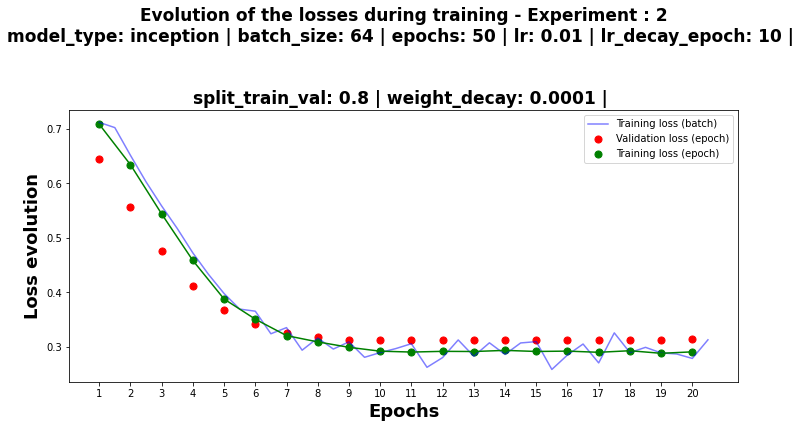

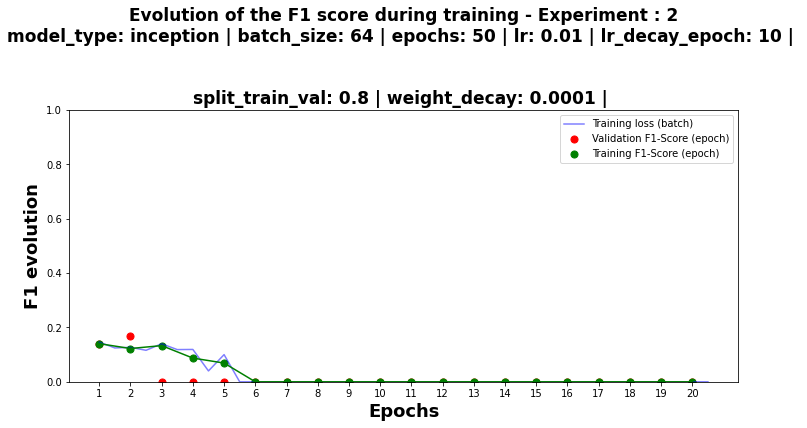

Number of epoch: 20
/content/drive/MyDrive/RAKUTEN/data/experiments/inception/3

LOOKING AT EXPERIMENT : 3
Don't have loss for exp num: 3
/content/drive/MyDrive/RAKUTEN/data/experiments/inception/4

LOOKING AT EXPERIMENT : 4


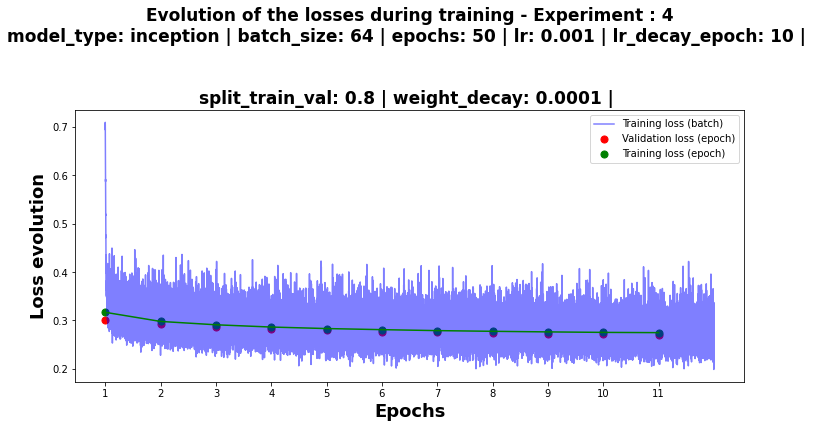

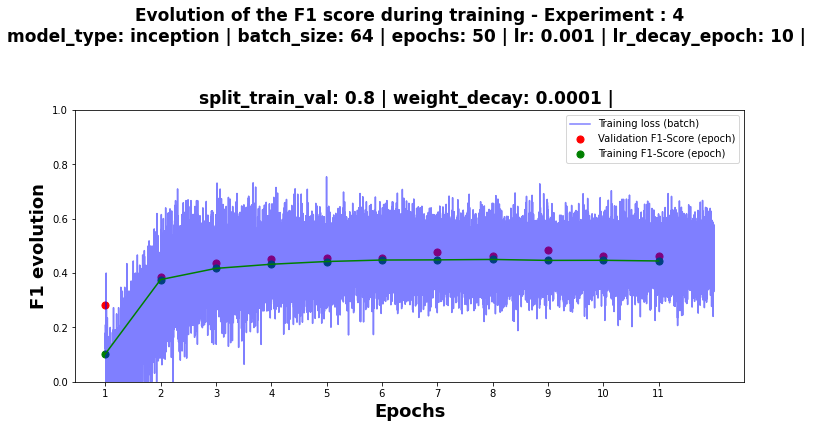

Number of epoch: 11
/content/drive/MyDrive/RAKUTEN/data/experiments/inception/5

LOOKING AT EXPERIMENT : 5


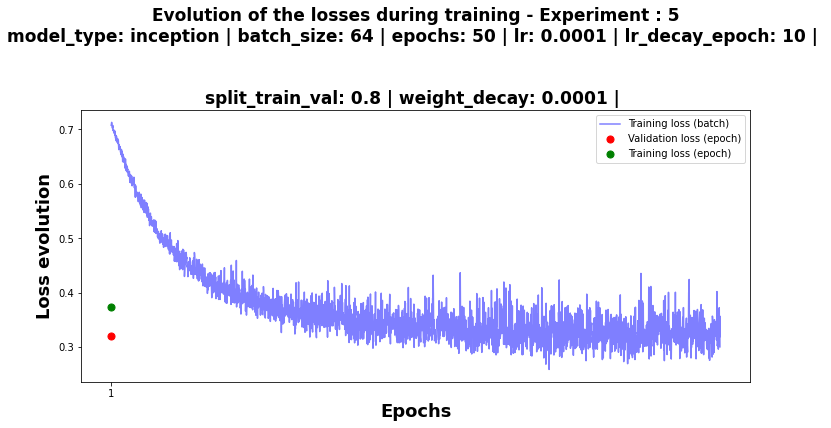

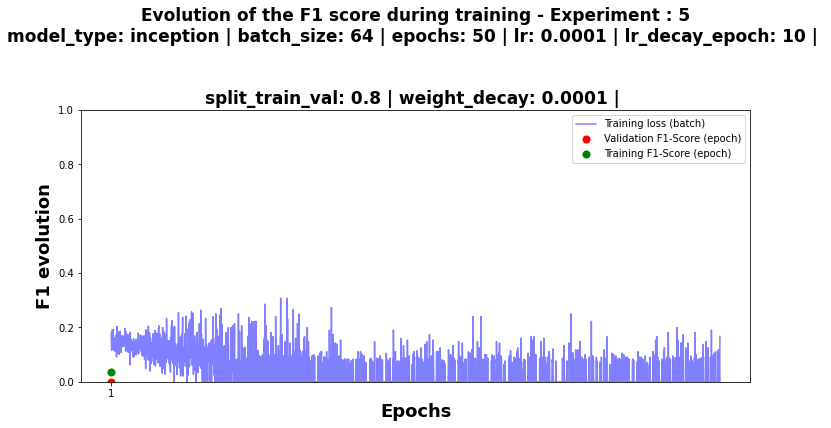

Number of epoch: 1
/content/drive/MyDrive/RAKUTEN/data/experiments/inception/6

LOOKING AT EXPERIMENT : 6


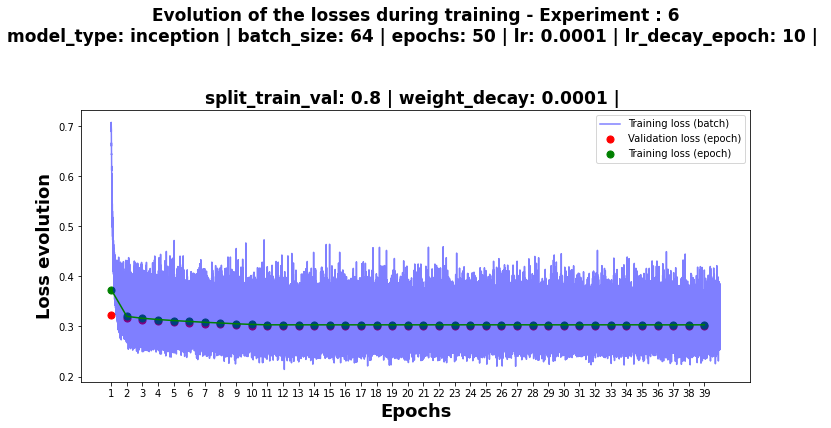

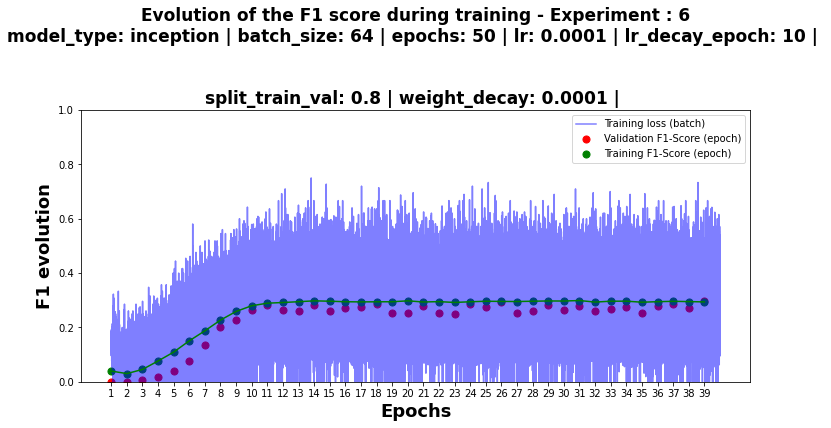

Number of epoch: 39
/content/drive/MyDrive/RAKUTEN/data/experiments/inception/7

LOOKING AT EXPERIMENT : 7


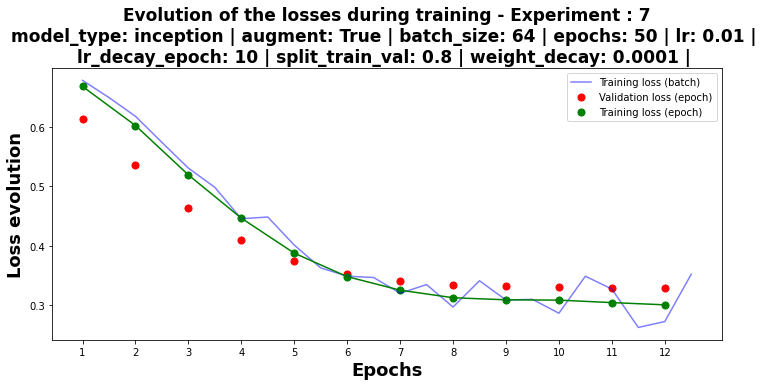

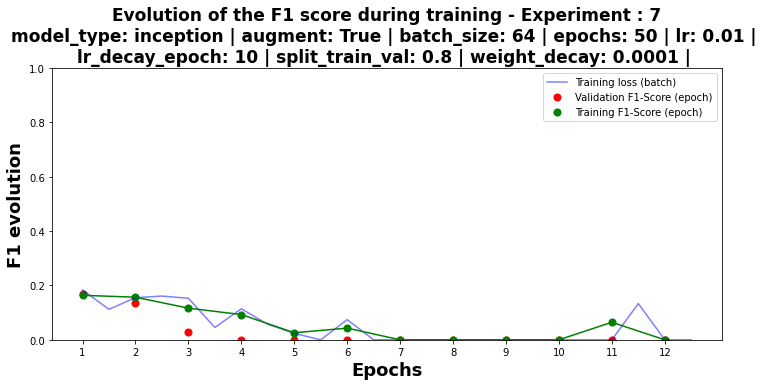

Number of epoch: 12
/content/drive/MyDrive/RAKUTEN/data/experiments/inception/8

LOOKING AT EXPERIMENT : 8
Don't have loss for exp num: 8
/content/drive/MyDrive/RAKUTEN/data/experiments/inception/9

LOOKING AT EXPERIMENT : 9
Don't have loss for exp num: 9
/content/drive/MyDrive/RAKUTEN/data/experiments/inception/10

LOOKING AT EXPERIMENT : 10
Don't have loss for exp num: 10
/content/drive/MyDrive/RAKUTEN/data/experiments/inception/11

LOOKING AT EXPERIMENT : 11
Don't have loss for exp num: 11
/content/drive/MyDrive/RAKUTEN/data/experiments/inception/12

LOOKING AT EXPERIMENT : 12
Don't have loss for exp num: 12
/content/drive/MyDrive/RAKUTEN/data/experiments/inception/13

LOOKING AT EXPERIMENT : 13
Don't have loss for exp num: 13
/content/drive/MyDrive/RAKUTEN/data/experiments/inception/14

LOOKING AT EXPERIMENT : 14
Don't have loss for exp num: 14
/content/drive/MyDrive/RAKUTEN/data/experiments/inception/15

LOOKING AT EXPERIMENT : 15
Don't have loss for exp num: 15
/content/drive/MyD

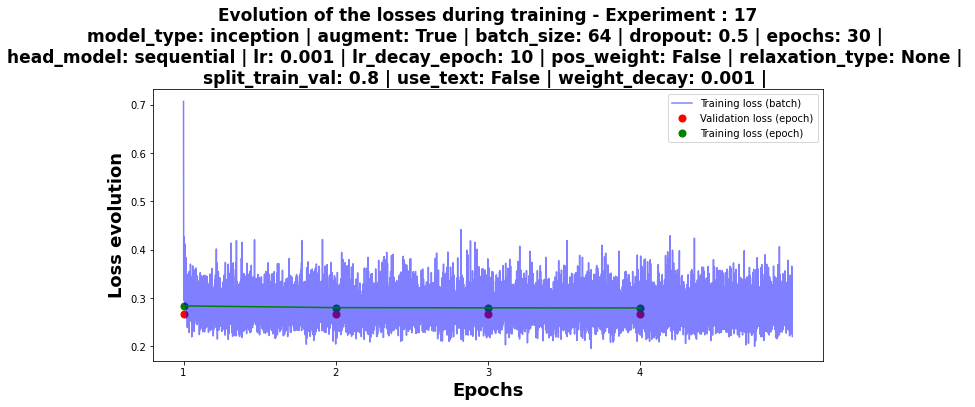

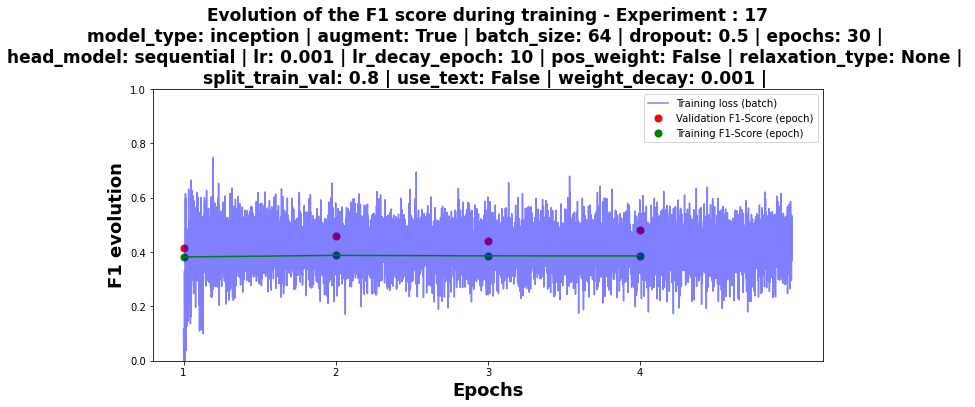

Number of epoch: 4


In [27]:
lookExperiments(model_type='inception', experiment_num = None)

In [10]:
glob(os.path.join(ROOT_DATA, 'experiments','inception','*'))

['/content/drive/MyDrive/RAKUTEN/data/experiments/inception/0',
 '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/1',
 '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/2',
 '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/3',
 '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/4',
 '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/5',
 '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/6',
 '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/7',
 '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/8',
 '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/9',
 '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/10',
 '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/11',
 '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/12',
 '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/13',
 '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/14',
 '/content/drive/MyDrive/RAKUTEN/da

In [23]:
param_dict = ['model_type', 'augment', 'batch_size', 'best_f1', 'betas', 'criterion', 'dropout', 'epochs', 'head_model', 'item_caption', 'lr', 'lr_decay_epoch', 'pos_weight', 'relaxation_type', 'split_train_val', 'troncature', 'use_text', 'weight_decay']

experiment_num=None
model_type='inception'
if experiment_num is None:
    vit_exp_list = glob(os.path.join(ROOT_DATA, 'experiments',model_type,'*'))
else:
    vit_exp_list = [os.path.join(ROOT_DATA, 'experiments',model_type,str(experiment_num))]
print(vit_exp_list)
for path in vit_exp_list:
    print(path)
    exp_num = os.path.basename(path)
    if exp_num=='0':
      continie
    path_json = os.path.join(path, 'experiment_log.json')

    print('\nLOOKING AT EXPERIMENT : {}'.format(exp_num))
    #try
    with open(path_json, 'r') as json_file:

        data = json.load(json_file)


['/content/drive/MyDrive/RAKUTEN/data/experiments/inception/0', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/1', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/2', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/3', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/4', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/5', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/6', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/7', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/8', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/9', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/10', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/11', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/12', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/13', '/content/drive/MyDrive/RAKUTEN/data/experiments/inception/14', '/content/drive/MyDrive/RAKUTEN/data/experiments/

NameError: ignored

In [22]:
path_json

NameError: ignored

/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/1

LOOKING AT EXPERIMENT : 1
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/1
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/2

LOOKING AT EXPERIMENT : 2
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/2
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/3

LOOKING AT EXPERIMENT : 3
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/3
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/4

LOOKING AT EXPERIMENT : 4
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/4
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/5

LOOKING AT EXPERIMENT : 5
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/5
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/6

LOOKING AT EXPERIMENT : 6
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/6
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/7

LOOKING AT EXPERIMENT : 7
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/7
/content/drive/MyDrive/RAKUTEN/data/exper

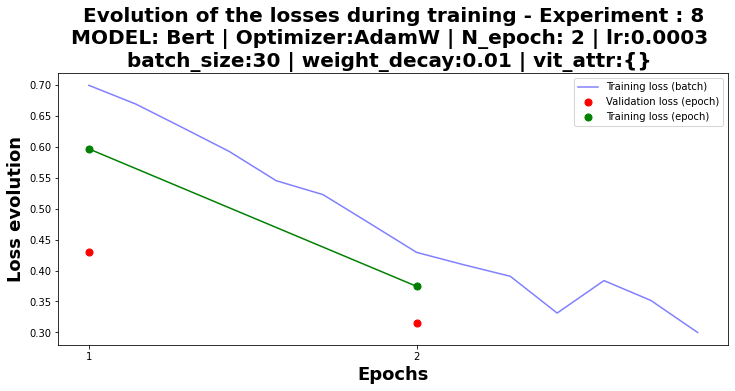

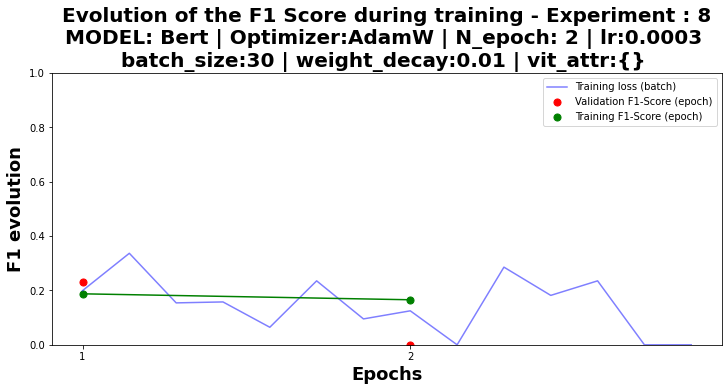

Number of epoch: 2
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/9

LOOKING AT EXPERIMENT : 9
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/9
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/10

LOOKING AT EXPERIMENT : 10


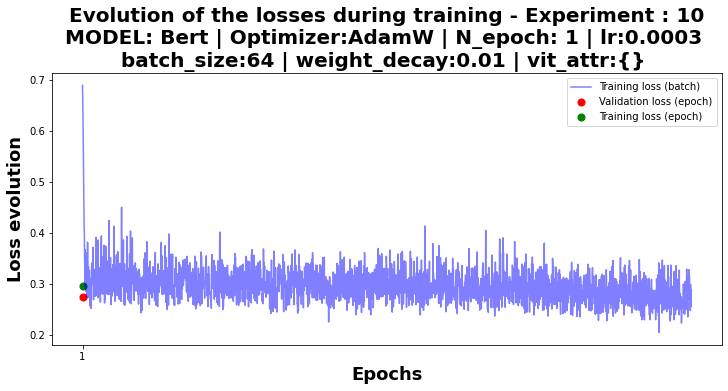

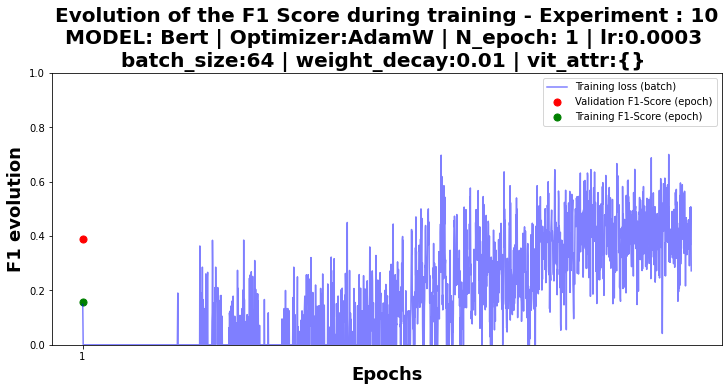

Number of epoch: 1
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/11

LOOKING AT EXPERIMENT : 11


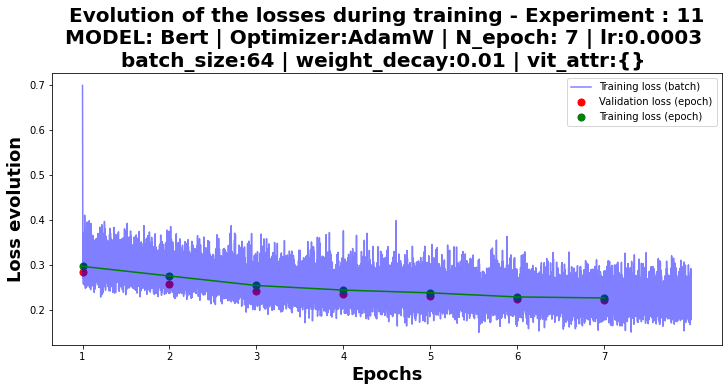

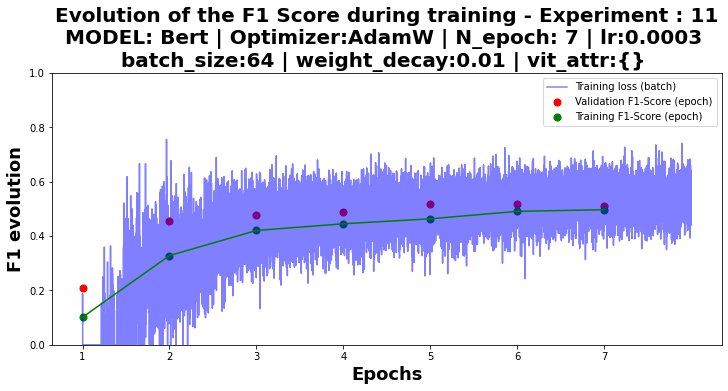

Number of epoch: 7
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/12

LOOKING AT EXPERIMENT : 12
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/12
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/13

LOOKING AT EXPERIMENT : 13
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/13
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/14

LOOKING AT EXPERIMENT : 14
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/14
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/15

LOOKING AT EXPERIMENT : 15
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/15
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/16

LOOKING AT EXPERIMENT : 16
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/16
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/17

LOOKING AT EXPERIMENT : 17
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/17
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/18

LOOKING AT EXPERIMENT : 18
/content/drive/MyDrive/RAKUTEN/data/experiments/Bert/18
/

In [55]:
vit_exp_list = glob(os.path.join(ROOT_DATA, 'experiments','Bert','*'))[1:]

for path in vit_exp_list:
    print(path)
    path_json = os.path.join(path, 'experiment_log.json')

    print('\nLOOKING AT EXPERIMENT : {}'.format(os.path.basename(path)))

  
    with open(path_json, 'r') as json_file:
        try:
          data = json.load(json_file)
            

          n_epoch = len(data['losses_train_epoch'])

          plt.figure(figsize=(12,5))
          plt.plot(data['losses_train_batch'], color = 'b', alpha = 0.5, label = 'Training loss (batch)')
          plt.scatter(int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), data['losses_val_epoch'], s=50, color = 'r', label = 'Validation loss (epoch)')
          plt.scatter(int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), data['losses_train_epoch'], s=50, color = 'g', label = 'Training loss (epoch)')
          plt.plot(int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), data['losses_train_epoch'], color = 'g')
          plt.title('Evolution of the losses during training - Experiment : {}\nMODEL: {} | Optimizer:{} | N_epoch: {} | lr:{} \nbatch_size:{} | weight_decay:{} | vit_attr:{} '.format(os.path.basename(path),
                                                                                                                                                                    data['model_type'],
                                                                                                                                                                    data['optimizer'] if 'optimizer' in list(data.keys()) else 'SGD' ,  
                                                                                                                                                                    n_epoch,
                                                                                                                                                                    data['lr'],
                                                                                                                                                                    data['batch_size'],
                                                                                                                                                                    data['weight_decay'],
                                                                                                                                                                    data['vit_attr']), fontsize=20, weight='bold')
          plt.xlabel('Epochs', fontsize=18, weight='bold')
          plt.ylabel('Loss evolution', fontsize=18, weight='bold')
          plt.xticks(ticks = int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), labels=[str(i) for i in np.arange(1,n_epoch+1)])
          _ = plt.legend()
          plt.show()
          
          plt.figure(figsize=(12,5))
          plt.plot(data['f1_train_batch'], color = 'b', alpha = 0.5, label = 'Training loss (batch)')
          plt.scatter(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_val_epoch'], s=50, color = 'r', label = 'Validation F1-Score (epoch)')
          plt.scatter(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_train_epoch'], s=50, color = 'g', label = 'Training F1-Score (epoch)')
          plt.plot(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_train_epoch'], color = 'g')
          plt.title('Evolution of the F1 Score during training - Experiment : {}\nMODEL: {} | Optimizer:{} | N_epoch: {} | lr:{} \nbatch_size:{} | weight_decay:{} | vit_attr:{} '.format(os.path.basename(path),
                                                                                                                                                                    data['model_type'],
                                                                                                                                                                    data['optimizer'] if 'optimizer' in list(data.keys()) else 'SGD' ,  
                                                                                                                                                                    n_epoch,
                                                                                                                                                                    data['lr'],
                                                                                                                                                                    data['batch_size'],
                                                                                                                                                                    data['weight_decay'],
                                                                                                                                                                    data['vit_attr']), fontsize=20, weight='bold')
          plt.xlabel('Epochs', fontsize=18, weight='bold')
          plt.ylabel('F1 evolution', fontsize=18, weight='bold')
          plt.xticks(ticks = int(len(data['losses_train_batch'])/n_epoch)*np.arange(n_epoch), labels=[str(i) for i in np.arange(1,n_epoch+1)])
          _ = plt.legend()
          plt.ylim((0,1))
          plt.show()

            
            

          print('Number of epoch: {}'.format(n_epoch))
        except:
            print(path)
          

In [ ]:
Bn_epoch

NameError: ignored

In [ ]:
def plot_loss(loss, name):
    
    plt.figure(figsize=(30,12))
    plt.plot(loss)
    plt.title('Values of {} across epochs'.format(name), fontsize=20, weight='bold')
    plt.xlabel('Epochs', fontsize=18, weight='bold')
    plt.ylabel(name+' evolution', fontsize=18, weight='bold')
    
plot_loss(data['losses_train_epoch'], 'losses_train_epoch')
plot_loss(data['losses_train_batch'], 'losses_train_batch')
plot_loss(data['f1_train_epoch'], 'f1_train_epoch')
plot_loss(data['f1_train_batch'], 'f1_train_batch')
plot_loss(data['losses_val_epoch'], 'losses_val_epoch')
plot_loss(data['losses_val_batch'], 'losses_val_batch')
plot_loss(data['f1_val_epoch'], 'f1_val_epoch')
plot_loss(data['f1_val_batch'], 'f1_val_batch')

In [ ]:
vit_exp_list = glob(os.path.join(ROOT_DATA, 'experiments','vit','*'))
plt.figure(figsize=(30,12))
for path in vit_exp_list:
    path_json = os.path.join(path, 'experiment_log.json')
    with open(path_json, 'r') as json_file:

        data = json.load(json_file)
            
        try:
            n_epoch = len(data['losses_train_epoch'])

            #plt.plot(data['f1_train_batch'], color = 'b', alpha = 0.5, label = 'Training loss (batch)')
            plt.scatter(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_val_epoch'], s=50, label = 'Validation F1-Score (epoch) - {}'.format(os.path.basename(path)))
            #plt.scatter(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_train_epoch'], s=50, color = 'g', label = 'Training F1-Score (epoch) - {}'.format(os.path.basename(path)))
            #plt.plot(int(len(data['f1_train_batch'])/n_epoch)*np.arange(n_epoch), data['f1_train_epoch'])

        except KeyError:
          print(path)
plt.xlabel('Epochs', fontsize=18, weight='bold')
plt.ylabel('F1 evolution', fontsize=18, weight='bold')
plt.xticks(ticks = np.arange(25), labels=[str(i) for i in np.arange(1,25+1)])
_ = plt.legend()
plt.ylim((0,1))
plt.show()

In [ ]:
from tools import displayPredictions

# Model creation
#model = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
#model.eval()
#model.classifier = nn.Linear(1024, 19) 
#displayPredictions(model, n=4)



# Data Preparation
train_df_X, train_df_Y, test_df_X, test_df_Y = splitTrainTest(XTrain, YTrain, fraction=0.8)
trainImageDataset = ImageDataset(train_df_X, train_df_Y, root_data)
testImageDataset = ImageDataset(test_df_X, test_df_Y, root_data)

trainLoader = torch.utils.data.DataLoader(trainImageDataset,batch_size=64, shuffle=True)
testLoader = torch.utils.data.DataLoader(testImageDataset,batch_size=64, shuffle=True)


# Model creation
modelTrained = retrieveModel(trained=True)
modelNaive = retrieveModel(trained=False)

#load images
image, label = next(iter(testLoader))
label = label.numpy().astype(int)


#Prediction
predTrained = modelTrained(image.cuda())
predNaive = modelNaive(image.cuda())
predTrained = (torch.sigmoid(predTrained).cpu().detach().numpy()>.5).astype(int)
predNaive =nbr_labels_positive = torch.tensor([25673,71831,34014,33338,2383,8303,21697,28814,8353,12597,25017,10378,24582,10355,23583,12911,3325,51751,14534]) #number of labels
nbr_labels_negative = nbr_labels_positive.sum()*torch.ones(19)-nbr_labels_positive
coeffs = nbr_labels_negative/nbr_labels_positive    #coefficients for each label
coeffs = coeffs.to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=coeffs) (torch.sigmoid(predNaive).cpu().detach().numpy()>.5).astype(int)

# Compute scores
f1Trained = f1_score(predTrained, label, average='weighted')
f1Naive = f1_score(predNaive, label, average='weighted')
print('F1 score for the Naive model is: {}\nF1 score for the Trained model is: {}')

In [ ]:
from tools import displayPredictions
